In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import softmax
import seaborn as sns
import statsmodels.api as sm
from scipy.optimize import minimize
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

# ignorov√°n√≠ warning≈Ø
warnings.simplefilter(action='ignore', category=FutureWarning)


## Bayesovsk√© odhady

In [204]:
# naƒçten√≠ dat pro prvn√≠ √∫lohu
first_task_data = pd.read_excel('Projekt-2_Data.xlsx', sheet_name='√öloha 1')
first_task_data


uloha_1 a)  uloha_1 b)_prior  skupina  uloha_1 b)_pozorov√°n√≠
0             2.0          3.634785        0               3.626656
1             2.0          2.868113        0               3.008269
2             1.0          2.149160        0               2.989829
3             3.0          4.263065        0               2.371630
4             0.0          2.594745        0               4.009366
...           ...               ...      ...                    ...
99995         NaN          1.725637     9999                    NaN
99996         NaN          4.048414     9999                    NaN
99997         NaN          3.000662     9999                    NaN
99998         NaN          3.058451     9999                    NaN
99999         NaN          4.487418     9999                    NaN

[100000 rows x 4 columns]

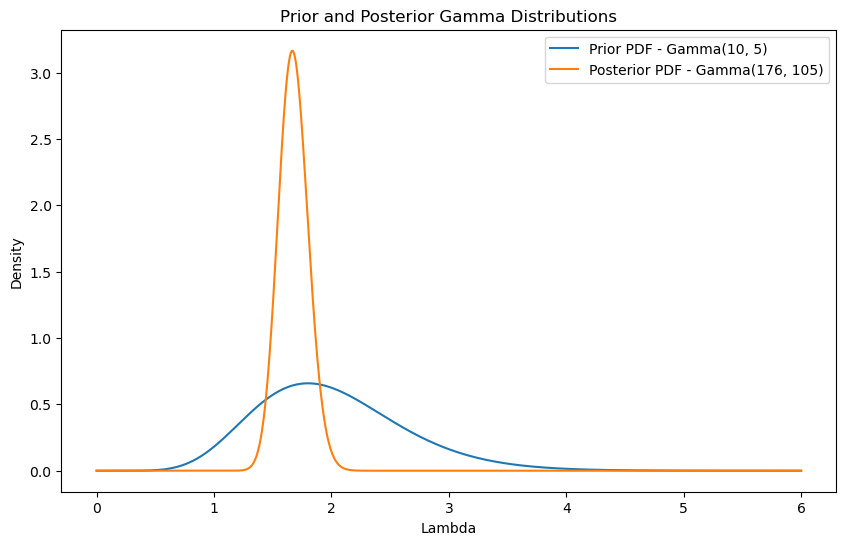

In [205]:
subtask_a_data = first_task_data["uloha_1 a)"].dropna()

alpha_prior = 10.0
beta_prior = 5.0

alpha_posterior = alpha_prior + subtask_a_data.sum()
beta_posterior = beta_prior + subtask_a_data.size

lambda_values = np.linspace(0, 6, 10000)

prior_pdf = stats.gamma.pdf(lambda_values, a=alpha_prior, scale= 1 / beta_prior)
posterior_pdf = stats.gamma.pdf(lambda_values, a=alpha_posterior, scale= 1 / beta_posterior)

plt.figure(figsize=(10, 6))
plt.plot(lambda_values, prior_pdf, label='Prior PDF - Gamma(10, 5)')
plt.plot(lambda_values, posterior_pdf, label='Posterior PDF - Gamma(176, 105)')
plt.title('Prior and Posterior Gamma Distributions')
plt.xlabel('Lambda')
plt.ylabel('Density')
plt.legend()
plt.show()


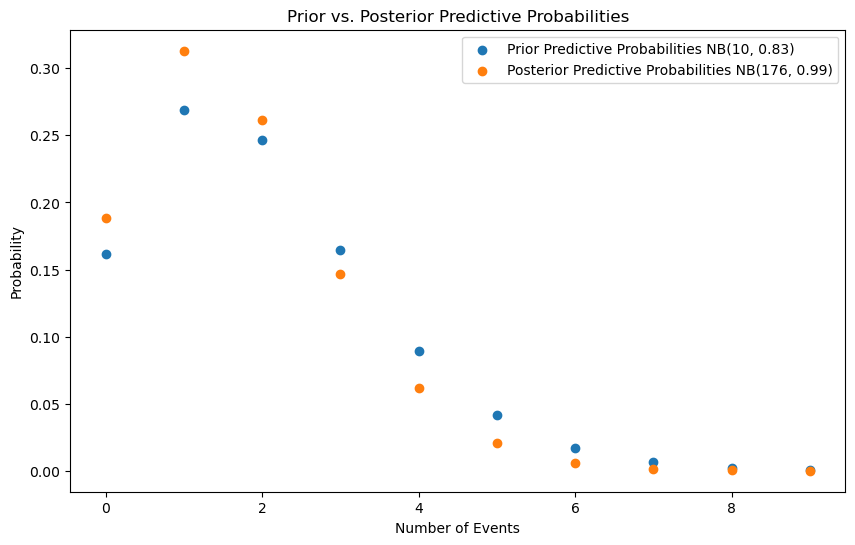

In [206]:
# parametry pro negativn√≠ binomick√© rozdƒõlen√≠ - NB(r, p)
r_prior = alpha_prior
r_posterior = alpha_posterior
p_prior = beta_prior / (beta_prior + 1)
p_posterior = beta_posterior / (beta_posterior + 1)

padding = 5
max_connections = subtask_a_data.max()

x_values = np.arange(0, max_connections + padding)

prior_predictive_probs = stats.nbinom.pmf(x_values, r_prior, p_prior)
posterior_predictive_probs = stats.nbinom.pmf(x_values, r_posterior, p_posterior)

plt.figure(figsize=(10, 6))
plt.scatter(x_values, prior_predictive_probs, label='Prior Predictive Probabilities - NB(10, 0.83)')
plt.scatter(x_values, posterior_predictive_probs, label='Posterior Predictive Probabilities - NB(176, 0.99)')
plt.title('Prior vs. Posterior Predictive Probabilities')
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.legend()
plt.show()


In [207]:
lower_percentile = 0.025  
upper_percentile = 0.975

lambda_prior_lower = stats.gamma.ppf(lower_percentile, a=alpha_prior, scale=1/beta_prior)
lambda_prior_upper = stats.gamma.ppf(upper_percentile, a=alpha_prior, scale=1/beta_prior)

lambda_posterior_lower = stats.gamma.ppf(lower_percentile, a=alpha_posterior, scale=1/beta_posterior)
lambda_posterior_upper = stats.gamma.ppf(upper_percentile, a=alpha_posterior, scale=1/beta_posterior)

print("95% interval spolehlivosti pro parametr ùúÜ z aprio. rozdƒõlen√≠: <{}, {}>".format(lambda_prior_lower, lambda_prior_upper))
print("95% interval spolehlivosti pro parametr ùúÜ z apost. rozdƒõlen√≠: <{}, {}>".format(lambda_posterior_lower, lambda_posterior_upper))


95% interval spolehlivosti pro parametr ùúÜ z aprio. rozdƒõlen√≠: <0.9590777392264868, 3.416960690283833>
95% interval spolehlivosti pro parametr ùúÜ z apost. rozdƒõlen√≠: <1.4376938284869922, 1.9327207471868797>


Na z√°kladƒõ spoƒç√≠tan√Ωch 95% interval≈Ø spolehlivosti m≈Ø≈æeme ≈ô√≠ci, ≈æe d√≠ky poskytnut√Ωm pozorov√°n√≠m jsme schopni v√Ωraznƒõ zp≈ôesnit odhad parametru $\lambda$, tedy v√Ωsledn√Ω interval aspoteriorn√≠ho rozdƒõlen√≠ je u≈æ≈°√≠ ne≈æ interval rozdƒõlen√≠ apriorn√≠ho.

In [208]:
lambda_posterior_mean = alpha_posterior / beta_posterior
lambda_posterior_median = stats.gamma.median(a=alpha_posterior, scale=1/beta_posterior)
lambda_posterior_mode = lambda_values[posterior_pdf.argmax()]

print("Bodov√Ω odhad parametru ùúÜ na z√°kladƒõ st≈ôedn√≠ hodnoty:", lambda_posterior_mean)
print("Bodov√Ω odhad parametru ùúÜ na z√°kladƒõ medi√°nu:", lambda_posterior_median)
print("Bodov√Ω odhad parametru ùúÜ na z√°kladƒõ modusu:", lambda_posterior_mode)


Bodov√Ω odhad parametru ùúÜ na z√°kladƒõ st≈ôedn√≠ hodnoty: 1.6761904761904762
Bodov√Ω odhad parametru ùúÜ na z√°kladƒõ medi√°nu: 1.6730169441241727
Bodov√Ω odhad parametru ùúÜ na z√°kladƒõ modusu: 1.666966696669667


Bodov√Ω odhad byl spoƒç√≠tan√Ω jak st≈ôedn√≠ hodnotou, medi√°nem, tak i modusem. V√Ωsledky jednotliv√Ωch odhad≈Ø jsou t√©mƒõ≈ô identick√©. To je zp≈Øsobeno t√≠m, ≈æe aspoteriorn√≠ rozdƒõlen√≠ parametru $\lambda$ se bl√≠≈æ√≠ norm√°ln√≠mu rozdƒõlen√≠.  

In [224]:
events_prior_mean = r_prior * (1.0 - p_prior) / p_prior
events_posterior_mean = r_posterior * (1.0 - p_posterior) / p_posterior

print("(Apriori) Bodov√Ω odhad poƒçtu pozorov√°n√≠ na z√°kladƒõ st≈ôedn√≠ hodnoty:", events_prior_mean)
print("(Aposteriori) Bodov√Ω odhad poƒçtu pozorov√°n√≠ na z√°kladƒõ st≈ôedn√≠ hodnoty:", events_posterior_mean)

(Apriori) Bodov√Ω odhad poƒçtu pozorov√°n√≠ na z√°kladƒõ st≈ôedn√≠ hodnoty: 1.9999999999999996
(Aposteriori) Bodov√Ω odhad poƒçtu pozorov√°n√≠ na z√°kladƒõ st≈ôedn√≠ hodnoty: 1.6761904761904758


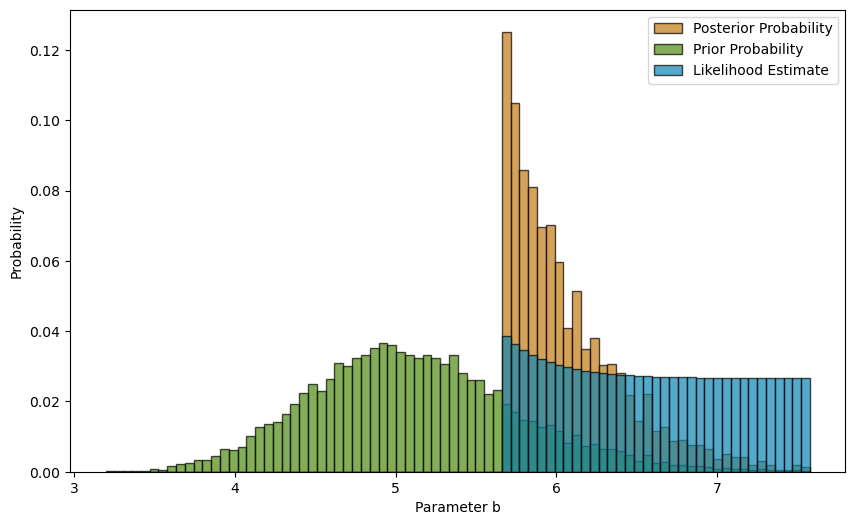

In [210]:
# z ka≈æd√© skupiny vybereme maxim√°ln√≠ hodnotu
subtask_b_prior = first_task_data[["uloha_1 b)_prior", "skupina"]].groupby("skupina").max()
subtask_b_observations = first_task_data["uloha_1 b)_pozorov√°n√≠"].dropna()

bin_values_num = 80

# soubor maxim√°ln√≠ch hodnot z jednotliv√Ωch skupin set≈ô√≠d√≠me do 80 bin≈Ø o stejn√© ≈°√≠≈ôce
prior_freq, bins = np.histogram(subtask_b_prior, bins=bin_values_num)
prior_prob = prior_freq / prior_freq.sum()

# vypoƒç√≠t√°me st≈ôedy bin≈Ø
bin_centers = 0.5 * (bins[1:] + bins[:-1])

mu = 3
sigma = 1
a_standard = (1 - mu) / sigma

log_likelihoods = []

# pro st≈ôedy v≈°ech bin≈Ø (reprezentuj√≠c√≠ parametr b) vypoƒç√≠t√°me logaritmus likelihoodu
# jin√Ωmi slovy vypoƒç√≠t√°me, jak dob≈ôe odpov√≠daj√≠ poskytnut√° pozorov√°n√≠ odseknut√©mu norm√°ln√≠mu
# rozdƒõlen√≠ pro r≈Øzn√© hodnoty parametru b
for b in bin_centers:
  b_standard = (b - mu) / sigma
  log_pdf_values = stats.truncnorm(a=a_standard, b=b_standard, loc=mu, scale=sigma).logpdf(subtask_b_observations)
  log_likelihoods.append(np.sum(log_pdf_values))


# pomoc√≠ softmaxu p≈ôevedeme logaritmy likelihood≈Ø na pravdƒõpodobnosti
likelihood_prob = softmax(log_likelihoods)


# vypoƒç√≠t√°me aposteriorn√≠ pravdƒõpodobnosti pomoc√≠ Bayesova vzorce
posterior_freq = prior_prob * likelihood_prob
posterior_prob = posterior_freq / posterior_freq.sum()

plt.figure(figsize=(10, 6))
plt.hist(bins[:-1], bins, weights=posterior_prob, label='Posterior Probability', alpha=0.7, color='#C47B12', edgecolor='black')
plt.hist(bins[:-1], bins, weights=prior_prob, label='Prior Probability', alpha=0.7, color='#508A11', edgecolor='black')
plt.hist(bins[:-1], bins, weights=likelihood_prob, label='Likelihood Estimate', alpha=0.7, color='#0F86B3', edgecolor='black')
plt.xlabel('Parameter b')
plt.ylabel('Probability')
plt.legend()
plt.show()


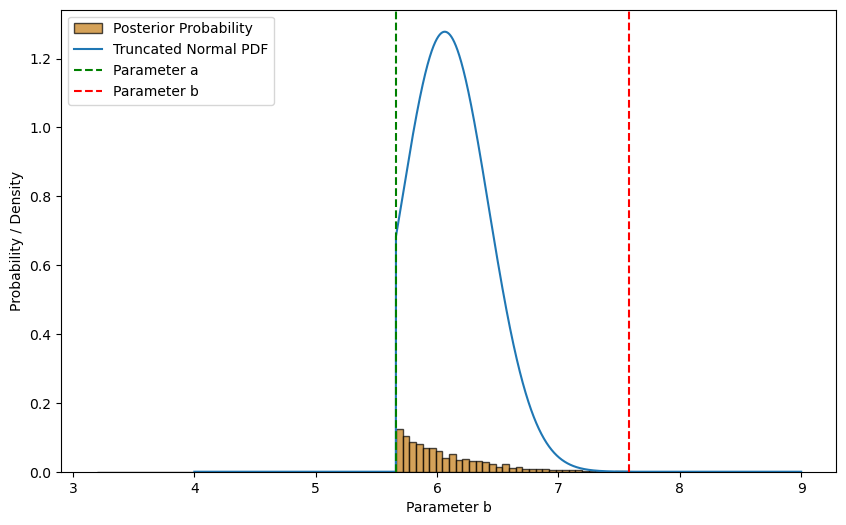

(Histogram) 95% interval spolehlivosti pro parametr b z apost. rozdƒõlen√≠: <5.688232034015019, 7.003430634180411>
(Hustota pravdƒõpodobnosti) 95% interval spolehlivosti pro parametr b z apost. rozdƒõlen√≠: <5.695559618614321, 6.788843572739788>


In [211]:
# v√Ωpoƒçet 95% intervalu spolehlivosti na z√°kladƒõ histogramu
cumulative_probs = np.cumsum(posterior_prob)

# najdeme bin, kter√Ω +- odpov√≠d√° 2.5 percentilu
lower_idx = np.argmax(cumulative_probs >= 0.025)
b_posteriro_lower_hist = bin_centers[lower_idx]

# najdeme bin, kter√Ω +- odpov√≠d√° 97.5 percentilu
upper_idx = np.argmax(cumulative_probs >= 0.975)
b_posteriro_upper_hist = bin_centers[upper_idx]

mean = np.sum(bin_centers * posterior_prob)
std_dev = np.sqrt(np.sum(posterior_prob * (bin_centers - mean)**2))

# v√Ωpoƒçet 95% intervalu spolehlivosti na z√°kladƒõ hustoty pravdƒõpodobnosti
a = posterior_prob.nonzero()[0][0]
a_standard = (bins[a] - mean) / std_dev
b_standard = (bins[-1] - mean) / std_dev

x_range = np.linspace(4, 9, 5000)

plt.figure(figsize=(10, 6))
plt.hist(bins[:-1], bins, weights=posterior_prob, label='Posterior Probability', alpha=0.7, color='#C47B12', edgecolor='black')
plt.plot(x_range, stats.truncnorm.pdf(x_range, a=a_standard, b=b_standard, loc=mean, scale=std_dev), label='Truncated Normal PDF',)
plt.axvline(x=bins[a], color='green', linestyle='--', label='Parameter a')
plt.axvline(x=bins[-1], color='red', linestyle='--', label='Parameter b')
plt.xlabel('Parameter b')
plt.ylabel('Probability / Density')
plt.legend()
plt.show()

b_posteriro_lower_pdf = stats.truncnorm.ppf(lower_percentile, a=a_standard, b=b_standard, loc=mean, scale=std_dev)
b_posteriro_upper_pdf = stats.truncnorm.ppf(upper_percentile, a=a_standard, b=b_standard, loc=mean, scale=std_dev)

print("(Histogram) 95% interval spolehlivosti pro parametr b z apost. rozdƒõlen√≠: <{}, {}>".format(b_posteriro_lower_hist, b_posteriro_upper_hist))
print("(Hustota pravdƒõpodobnosti) 95% interval spolehlivosti pro parametr b z apost. rozdƒõlen√≠: <{}, {}>".format(b_posteriro_lower_pdf, b_posteriro_upper_pdf))


In [212]:
mode = bin_centers[posterior_prob.argmax()]
median = stats.truncnorm.median(a=a_standard, b=b_standard, loc=mean, scale=std_dev)

print("Bodov√Ω odhad parametru b na z√°kladƒõ st≈ôedn√≠ hodnoty:", mean)
print("Bodov√Ω odhad parametru b na z√°kladƒõ medi√°nu:", median)
print("Bodov√Ω odhad parametru b na z√°kladƒõ modusu:", mode)


Bodov√Ω odhad parametru b na z√°kladƒõ st≈ôedn√≠ hodnoty: 6.063248915799402
Bodov√Ω odhad parametru b na z√°kladƒõ medi√°nu: 6.122678249666167
Bodov√Ω odhad parametru b na z√°kladƒõ modusu: 5.688232034015019


## Line√°rn√≠ regrese

In [213]:
# naƒçten√≠ dat pro druhou √∫lohu
second_task_data = pd.read_excel('Projekt-2_Data.xlsx', sheet_name='√öloha 2')

# vytvo≈ô√≠me dummy promƒõnn√© pro kategorickou promƒõnnou OSType
# IS_MacOS == 0 ^ IS_Windows == 0 ^ IS_iOS == 0 => IS_Android == 1
dummy_variables = pd.get_dummies(second_task_data['OSType'], drop_first=True, prefix="IS").astype(float)  

# z data framu odstran√≠me p≈Øvodn√≠ kategorickou promƒõnnou a p≈ôid√°me dummy promƒõnn√©
second_task_data = second_task_data.drop('OSType', axis=1).join(dummy_variables)
initial_data = second_task_data.copy()
second_task_data.head()


ActiveUsers  InteractingPct  ScrollingPct  Ping [ms]  IS_MacOS  IS_Windows  \
0         4113          0.8283        0.1717         47       0.0         0.0   
1         7549          0.3461        0.6539         46       0.0         0.0   
2         8855          0.2178        0.7822         55       0.0         1.0   
3         8870          0.0794        0.9206         56       0.0         0.0   
4         9559          0.7282        0.2718         76       1.0         0.0   

   IS_iOS  
0     1.0  
1     1.0  
2     0.0  
3     0.0  
4     0.0

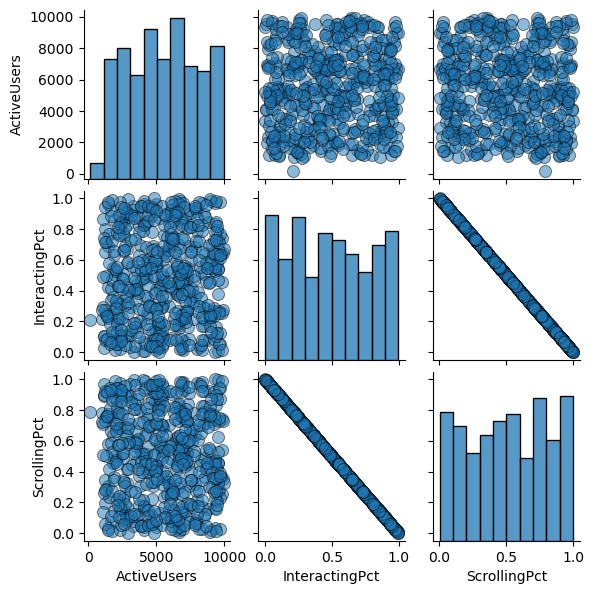

In [214]:
predictors = second_task_data[['ActiveUsers', 'InteractingPct', 'ScrollingPct']]

# vztahy jednotliv√Ωch prediktor≈Ø
sns.pairplot(predictors, plot_kws={'alpha': 0.5, 's': 75, 'edgecolor': 'k'}, height=2.)


In [215]:
# promƒõnn√© InteractingPct a ScrollingPct jsou lin√°rnƒõ z√°visl√©, jednu z nich tedy odstran√≠me
second_task_data.drop('InteractingPct', axis=1, inplace=True)
second_task_data.head()


ActiveUsers  ScrollingPct  Ping [ms]  IS_MacOS  IS_Windows  IS_iOS
0         4113        0.1717         47       0.0         0.0     1.0
1         7549        0.6539         46       0.0         0.0     1.0
2         8855        0.7822         55       0.0         1.0     0.0
3         8870        0.9206         56       0.0         0.0     0.0
4         9559        0.2718         76       1.0         0.0     0.0

### V√Ωchoz√≠ pln√Ω kvadratick√Ω model
$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1^2 + \beta_4 X_2^2 + \beta_5 X_1X_2 + \beta_6 C_1 + \beta_7 C_2 + \beta_8 C_3 + \beta_9 X_1C_1 + \beta_{10} X_1C_2 + \beta_{11} X_1C_3 + \beta_{12} X_2C_1 + \beta_{13} X_2C_2 + \beta_{14} X_2C_3 + \epsilon$

$Y$ je z√°visl√° promƒõnn√° `Ping [ms]`. \
$X_1, X_2$ jsou nez√°visl√© spojit√© promƒõnn√© `ActiveUsers` a `ScrollingPct`. \
$C_1, C_2, C_3$ jsou kategorick√© promƒõnn√© `IS_MacOS`, `IS_Windows` a `IS_iOS`. \
$\beta_0, \beta_1, \beta_2, \dotsc, \beta_14$ jsou hledan√© koeficienty. \
$\epsilon$ reprezntuje chybu zp≈Øsobenou ≈°umem ve vstupn√≠ch datech.



In [216]:
# standardizace prediktor≈Ø do intervalu <-1, 1>
min_values = second_task_data.drop(['Ping [ms]'], axis=1).min(axis=0)
max_values = second_task_data.drop(['Ping [ms]'], axis=1).max(axis=0)
predict_cols =  second_task_data.columns.drop('Ping [ms]')
second_task_data[predict_cols] = -1 + 2 * (second_task_data[predict_cols] - min_values) / (max_values - min_values) 

# p≈ôid√°n√≠ kvadratick√Ωch a sm√≠≈°en√Ωch ƒçlen≈Ø
second_task_data['ActiveUsers_squared'] = second_task_data['ActiveUsers'] ** 2
second_task_data['ScrollingPct_squared'] = second_task_data['ScrollingPct'] ** 2
second_task_data['ActiveUsers_ScrollingPct'] = second_task_data['ActiveUsers'] * second_task_data['ScrollingPct']
second_task_data['ActiveUsers_IS_MacOS'] = second_task_data['ActiveUsers'] * second_task_data['IS_MacOS']
second_task_data['ActiveUsers_IS_Windows'] = second_task_data['ActiveUsers'] * second_task_data['IS_Windows']
second_task_data['ActiveUsers_IS_iOS'] = second_task_data['ActiveUsers'] * second_task_data['IS_iOS']
second_task_data['ScrollingPct_IS_MacOS'] = second_task_data['ScrollingPct'] * second_task_data['IS_MacOS']
second_task_data['ScrollingPct_IS_Windows'] = second_task_data['ScrollingPct'] * second_task_data['IS_Windows']
second_task_data['ScrollingPct_IS_iOS'] = second_task_data['ScrollingPct'] * second_task_data['IS_iOS']

init_predictors = ['ActiveUsers', 'ActiveUsers_squared', 'ScrollingPct', 'ScrollingPct_squared', 'ActiveUsers_ScrollingPct', 
              'IS_MacOS', 'IS_Windows', 'IS_iOS', 'ActiveUsers_IS_MacOS', 'ActiveUsers_IS_Windows', 'ActiveUsers_IS_iOS', 
              'ScrollingPct_IS_MacOS', 'ScrollingPct_IS_Windows', 'ScrollingPct_IS_iOS']

X = sm.add_constant(second_task_data[init_predictors])
y = second_task_data['Ping [ms]']

# vytvo≈ôen√≠ v√Ωchoz√≠ho modelu
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          5.18e-186
Time:                        22:20:43   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [217]:
continue_removal = True
alpha = 0.05

while continue_removal:
    p_values = model.pvalues
    highest_p_value_idx = p_values.idxmax()

    if p_values[highest_p_value_idx] > alpha:
        X.drop(columns=[highest_p_value_idx], inplace=True)
        model = sm.OLS(y, X).fit()
        print(model.summary())
    else:
        continue_removal = False


                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     202.8
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          3.58e-187
Time:                        22:20:43   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3225.
Df Residuals:                     488   BIC:                             3284.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

                               VIF
const                     5.494647
ActiveUsers               4.124834
ActiveUsers_squared       1.143915
ScrollingPct              1.031438
ActiveUsers_ScrollingPct  1.036824
IS_MacOS                  1.728634
IS_Windows                1.713664
IS_iOS                    1.650624
ActiveUsers_IS_MacOS      2.232872
ActiveUsers_IS_Windows    2.165669
ActiveUsers_IS_iOS        2.286647


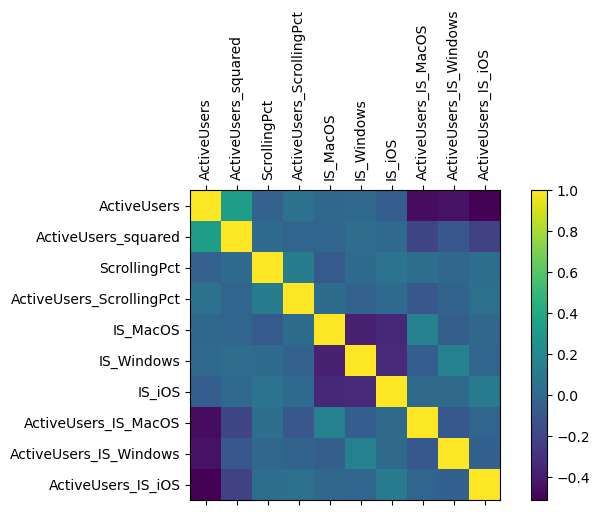

In [218]:
# VIF
vif_df = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
               index=X.columns).to_frame()
vif_df.columns = ['VIF']
print(vif_df)

# korelaƒçn√≠ matice
X_no_const = X.copy().drop(columns=['const'])
plt.figure(figsize=(8, 4))
plt.matshow(X_no_const.corr(),fignum=1)
plt.xticks(range(len(X_no_const.columns)), X_no_const.columns, rotation=90)
plt.yticks(range(len(X_no_const.columns)), X_no_const.columns)
plt.colorbar()
plt.show()


Pozorov√°n√≠ s velkou Cook's distance - indexy: []
Pozorov√°n√≠ s velkou p√°kou - indexy: [476]
Pozorov√°n√≠ s velk√Ωmi rezidui - indexy: [ 82 255 476]


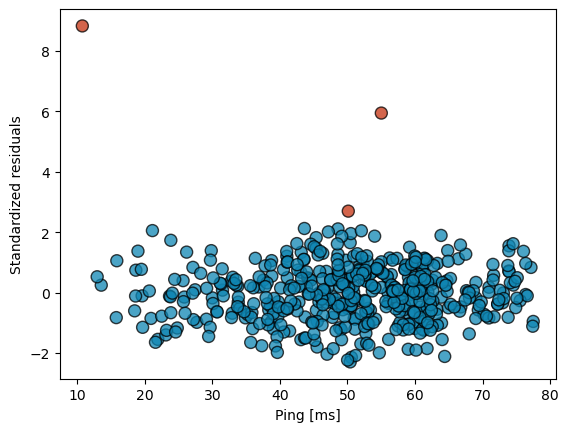

In [219]:
influence = model.get_influence()

# podez≈ôel√© hodnoty - p_value < 0.05
_, p_value = influence.cooks_distance
cooks_distance_outliers_idxs = np.where(p_value < 0.05)[0]
print("Pozorov√°n√≠ s velkou Cook's distance - indexy:", cooks_distance_outliers_idxs)

# podez≈ôel√© hodnoty - leverage >  3 x poƒçet parametr≈Ø / poƒçet pozorov√°n√≠
leverage = influence.hat_matrix_diag
leverage_outliers_idx = np.where(leverage > 3 * model.params.size / X.shape[0])[0]
print("Pozorov√°n√≠ s velkou p√°kou - indexy:",leverage_outliers_idx)

# podez≈ôel√© hodnoty - absolutn√≠ hodnoty standardizovan√Ωch rezidu√≠ vƒõt≈°√≠ ne≈æ 2.5
standardized_residuals = influence.resid_studentized_internal
resid_outliers_idxs = np.where(np.abs(standardized_residuals) > 2.5)[0]
print("Pozorov√°n√≠ s velk√Ωmi rezidui - indexy:", resid_outliers_idxs)

all_outliers_idxs = np.unique(np.concatenate((cooks_distance_outliers_idxs, leverage_outliers_idx, resid_outliers_idxs)))

colors = np.array(['#0F86B3'] * X.shape[0])
colors[all_outliers_idxs] = '#C53110'

plt.scatter(model.fittedvalues, standardized_residuals, alpha=0.75, s=75, edgecolor='k', c=colors)
plt.xlabel('Ping [ms]')
plt.ylabel('Standardized residuals')
plt.show()


In [220]:
# odstranƒõn√≠ podez≈ôel√Ωch pozorov√°n√≠
X.drop([476, 255], inplace=True)

# re-normalizace prediktor≈Ø
min_values = X.drop(['const'], axis=1).min(axis=0)
max_values = X.drop(['const'], axis=1).max(axis=0)
predict_cols =  X.columns.drop('const')
X[predict_cols] = -1 + 2 * (X[predict_cols] - min_values) / (max_values - min_values) 

initial_data.drop([476, 255], axis=0, inplace=True)
y.drop([476, 255], inplace=True)

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     349.9
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          1.28e-215
Time:                        22:20:43   Log-Likelihood:                -1528.7
No. Observations:                 500   AIC:                             3079.
Df Residuals:                     489   BIC:                             3126.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Fin√°ln√≠ regresen√≠ model

$Ping [ms] = 49.85 + 19.03 \times ActiveUsers - 5.56 \times ActiveUsers^2 -9.4 \times ScrollingPct + 7.63 \times ActiveUsers\_ScrollingPct + 4.13 \times IS\_MacOS + 2.0 \times IS\_Windows - 2.63 \times IS\_iOS + 4.25 \times ActiveUsers\_IS\_MacOS - 1.83 \times ActiveUsers\_IS\_Windows - 2.53 \times ActiveUsers\_IS\_iOS$

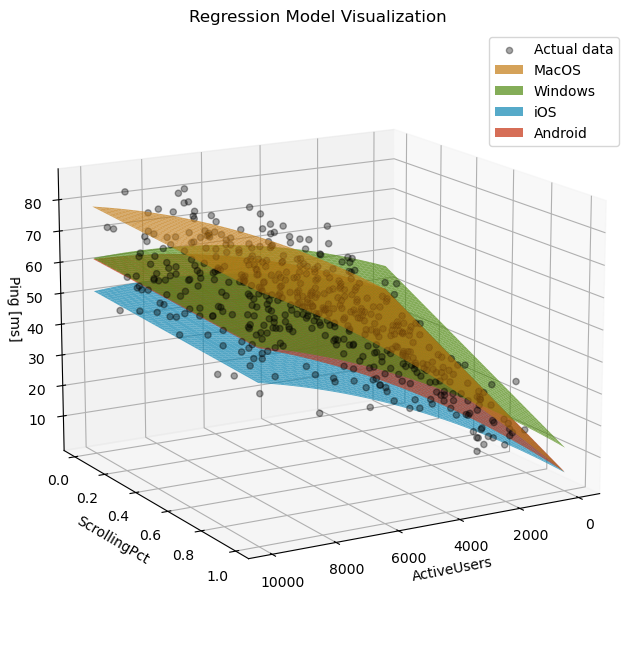

In [221]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# vykreslen√≠ namƒõ≈ôen√Ωch hodnot
ax.scatter(initial_data['ActiveUsers'], initial_data['ScrollingPct'], y, color='black', alpha=0.35 , label='Actual data')

number_of_points = 100

x_axis_points = np.linspace(-1, 1, number_of_points)
y_axis_points = np.linspace(-1, 1, number_of_points)

x_surf, y_surf = np.meshgrid(x_axis_points, y_axis_points)

flattened_x = x_surf.flatten()
flattened_y = y_surf.flatten()

# denormalizace osy x a y
x_surf_denormalized = 10000 * (x_surf + 1) / 2
y_surf_denormalized = (y_surf + 1) / 2

os_cases = (
    ('MacOS', [1.0, -1.0, -1.0], "#C47B12"),
    ('Windows', [-1.0, 1.0, -1.0], "#508A11"),
    ('iOS', [-1.0, -1.0, 1.0] , "#0F86B3"),
    ('Android', [-1.0, -1.0, -1.0] , "#C53110")
)

base_predict_df = pd.DataFrame({
    'ActiveUsers': flattened_x, 
    'ActiveUsers_squared': flattened_x ** 2,
    'ScrollingPct': flattened_y,
    'ActiveUsers_ScrollingPct': flattened_y * flattened_x,
})

# vykreslen√≠ zak≈ôiven√Ωch ploch pro jednotliv√© operaƒçn√≠ syst√©my
for os_name, os_values, os_color in os_cases:
  predict_df = sm.add_constant(base_predict_df.copy())

  predict_df[['IS_MacOS','IS_Windows','IS_iOS']] = os_values
  predict_df[['ActiveUsers_IS_MacOS', 'ActiveUsers_IS_Windows', 'ActiveUsers_IS_iOS']] = (
        predict_df['ActiveUsers'].values[:, np.newaxis] * np.array(os_values)
    )
  
  fittedY = model.predict(predict_df)

  fittedY = np.array(fittedY).reshape(x_surf_denormalized.shape)

  ax.plot_surface(x_surf_denormalized, y_surf_denormalized, fittedY, alpha=0.7, label=os_name, facecolor=os_color)

ax.set_xlabel('ActiveUsers')
ax.set_ylabel('ScrollingPct')
ax.set_zlabel('Ping [ms]', labelpad=0)
ax.view_init(elev=15, azim=60) 
plt.title('Regression Model Visualization')
plt.legend()
plt.show()


### 2.2 Identifikace parametr≈Ø s nejproblematiƒçtƒõj≈°√≠ hodnotou odezvy

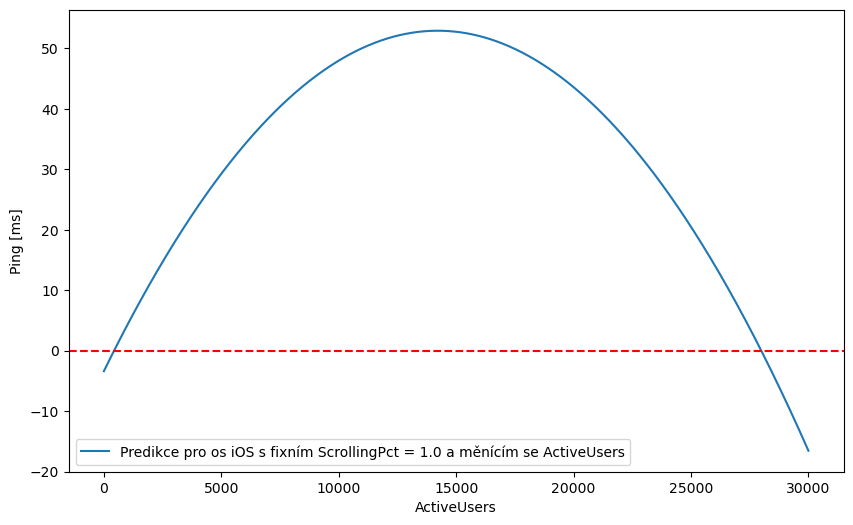

In [222]:
max_au, max_scroll = initial_data[['ActiveUsers', 'ScrollingPct']].max(axis=0)
min_au, min_scroll = initial_data[['ActiveUsers', 'ScrollingPct']].min(axis=0)

number_of_points = 2000
active_users_max_num = 30000

# vzorkov√°n√≠ hodnot ActiveUsers od 1 a≈æ po 22000
x_axis_points = np.linspace(1, active_users_max_num, number_of_points)

# normalizace vstupn√≠ch hodnot
active_users = -1 + 2 * (x_axis_points - min_au) / (max_au - min_au)
scrolling_pct = -1 + 2 * (np.array([1.0]*number_of_points) - min_scroll) / (max_scroll - min_scroll) 

# vytvo≈ôen√≠ data framu pro predikci
unseen_data = pd.DataFrame({
    'const': [1.0] * number_of_points, 
    'ActiveUsers': active_users,
    'ActiveUsers_squared' : active_users ** 2,
    'ScrollingPct': scrolling_pct,
    'ActiveUsers_ScrollingPct' : active_users * scrolling_pct,
    'IS_MacOS': [-1.0] * number_of_points,
    'IS_Windows': [-1.0] * number_of_points,
    'IS_iOS': [1.0] * number_of_points,
    'ActiveUsers_IS_MacOS': active_users * -1.0,
    'ActiveUsers_IS_Windows': active_users * -1.0,
    'ActiveUsers_IS_iOS': active_users * 1.0,
})

predictions = model.predict(unseen_data)

plt.figure(figsize=(10, 6))
plt.plot(x_axis_points, predictions, label='Predikce pro os iOS s fixn√≠m ScrollingPct = 1.0 a mƒõn√≠c√≠m se ActiveUsers')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('ActiveUsers')
plt.ylabel('Ping [ms]')
plt.legend()
plt.show()

### 2.3 Odezva pro u≈æivatele s Windows

In [223]:
# vypoƒç√≠t√°me pr≈Ømƒõrnou hodnotu ActiveUsers a ScrollingPct
mean_au, mean_scroll = initial_data[['ActiveUsers', 'ScrollingPct']].mean(axis=0)

# > 0.5 => IS_Windows == 1
windows_ping_mean = initial_data[initial_data["IS_Windows"] > 0.5][["Ping [ms]"]].mean().values[0]

# normalizujeme je
active_users = -1 + 2 * (mean_au - min_au) / (max_au - min_au)
scrolling_pct = -1 + 2 * (mean_scroll - min_scroll) / (max_scroll - min_scroll)

# vytvo≈ô√≠me data frame pro predikci
windows_average_load = pd.DataFrame({
    'const': [1.0], 
    'ActiveUsers': [active_users],
    'ActiveUsers_squared' : [active_users ** 2],
    'ScrollingPct': [scrolling_pct],
    'ActiveUsers_ScrollingPct' : [active_users * scrolling_pct],
    'IS_MacOS': [-1.0],
    'IS_Windows': [1.0],
    'IS_iOS': [-1.0],
    'ActiveUsers_IS_MacOS': [-active_users],
    'ActiveUsers_IS_Windows': [active_users],
    'ActiveUsers_IS_iOS': [-active_users],
})

windows_ping_prediction = model.predict(windows_average_load)[0]
summary_frame = model.get_prediction(windows_average_load).summary_frame(alpha=0.05) 

print("Predikce pro Windows:", round(windows_ping_prediction, 2))
print("Pr≈Ømƒõrn√Ω ping pro Windows:", round(windows_ping_mean, 2))

print(f'Konfidenƒçn√≠ interval: <{round(summary_frame["mean_ci_lower"][0], 2)}, {round(summary_frame["mean_ci_upper"][0], 2)}>')
print(f'Predikƒçn√≠ interval: <{round(summary_frame["obs_ci_lower"][0], 2)}, {round(summary_frame["obs_ci_upper"][0], 2)}>')


Predikce pro Windows: 50.19
Pr≈Ømƒõrn√Ω ping pro Windows: 51.43
Konfidenƒçn√≠ interval: <49.2, 51.17>
Predikƒçn√≠ interval: <39.91, 60.46>
